# Training models on campaigns in the same area 
## OP 1

This time i split the test and training data as 70% in one area and 30% in another

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

In [2]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

## Processing functions

In [3]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

## Random Forest functions

In [4]:
def rf(X_train, X_test, mode_train, mode_test, campaigns, test_campaigns, features, n_estimators=100, max_depth=None, min_samples_leaf=1):
    permutation = np.random.permutation(X_train.index)
    X_train_randomized = X_train.reindex(permutation).reset_index(drop=True)
    mode_train_randomized = mode_train.reindex(permutation).reset_index(drop=True)

    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    smote = SMOTE()
    # rus = RandomUnderSampler() 
    X_train_balanced, mode_train_balanced = smote.fit_resample(X_train_randomized[features], mode_train_randomized['Mode'])
    # X_train_balanced, mode_train_balanced = rus.fit_resample(X_train_balanced, mode_train_balanced)

    rf.fit(X_train_balanced, mode_train_balanced)

    if len(test_campaigns) == 1:
        y_pred = rf.predict(X_test[features])

        accuracy = accuracy_score(mode_test['Mode'], y_pred)
        precision = precision_score(mode_test['Mode'], y_pred)
        recall = recall_score(mode_test['Mode'], y_pred)

        y_true = mode_test['Mode']

        

        train_pred = rf.predict(X_train[features])

        train_accuracy = accuracy_score(mode_train['Mode'], train_pred)
        train_precision = precision_score(mode_train['Mode'], train_pred)
        train_recall = recall_score(mode_train['Mode'], train_pred)

        train_true = mode_train['Mode']
    else:
        X_test_test = X_test[X_test['campaign'] == test_campaigns[0]]
        X_test_mode = mode_test[mode_test['campaign'] == test_campaigns[0]]
        
        y_pred = rf.predict(X_test_test[features])

        y_pred_total = rf.predict(X_test[features])
        accuracy = accuracy_score(mode_test['Mode'], y_pred_total)
        precision = precision_score(mode_test['Mode'], y_pred_total)
        recall = recall_score(mode_test['Mode'], y_pred_total)

        y_true = X_test_mode['Mode']

        X_train_test = X_train[X_train['campaign'] == campaigns[0]]
        X_train_mode = mode_train[mode_train['campaign'] == campaigns[0]]

        train_pred = rf.predict(X_train_test[features])

        train_pred_total = rf.predict(X_train[features])
        train_accuracy = accuracy_score(mode_train['Mode'], train_pred_total)
        train_precision = precision_score(mode_train['Mode'], train_pred_total)
        train_recall = recall_score(mode_train['Mode'], train_pred_total)

        train_true = X_train_mode['Mode']

    results = {'Accuracy': round(accuracy, 3),
               'Precision': round(precision, 3),
               'Recall': round(recall, 3),
               'y_true' : y_true,
               'y_pred' : y_pred,
               'train_true': train_true,
               'train_pred': train_pred,
               'Accuracy_train': round(train_accuracy, 3),
               'Precision_train': round(train_precision, 3),
               'Recall_train': round(train_recall, 3),
               'model': rf}
    return results

def plot_mode(pred, true, operator:str, comb:str, campaigns:list, test_campaigns:list, test_train='Test', colors=mode_colors):
    f = plt.figure(figsize=(16, 6))
    plt.grid(zorder=0)
    plt.plot(pred, color=colors[1], label='Predicted', zorder=2)
    plt.plot(true + 2, color=colors[3], label='True', zorder=3)
    plt.xlabel('Index / Timestamp')
    plt.ylabel('HO')
    plt.ylim((-0.2, 3.4))
    plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
    plt.title(f'{test_train} data -- {operator}\nParameters: {comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
    plt.legend(ncols=3, loc='best')
    plt.show()

In [5]:
# Parameters
tf.random.set_seed(4567)
dataset = 'datasets/Op1_merged.csv'
operator = 'Operator 1'

# LSTM
n_steps_in = 2
n_steps_out = 1

n_first_units = 5
n_second_units = 10

# Random Forest
n_estimators = 100
max_depth = 10

In [39]:
feature_selection = [#['RSRP'], ['SINR'], ['RSRQ'], 
                    #  ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ'],
                     #['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                    #  ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                     ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

In [8]:
overlap_1 = ['Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode',
             'Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
             'Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
             'Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode',
             'Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode']

overlap_2 = ['Ping_UNIDATA_4G5G_TIM_Walking_Termini_to_DIET', 
             'Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Termini', 
             'Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel', 
             'Interactivity_gaming_4G5G_TIM_Walking_Termini_to_DIET_Test_2_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel']

overlap_3 = ['Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia', 
             'Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia_Part_2', 
             'Interactivity_gaming_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia', 
             'Capacity_Ookla_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode']

overlap_4 = ['Ping_UNIDATA_4G5G_TIM_Driving_Luca', 
             'Interactivity_gaming_4G5G_TIM_Driving_Luca', 
             'Capacity_Ookla_4G5G_Tim_Driving_Luca']

### Indices for test and train on overlap_1
- Route 0: train[1500::], test[0:1500]
- Route 1: train[0:1500], test[1500::]
- Route 2: train[0:1200], test[1200::]
- Route 3: train[5400::], ------------
- Route 4: train[0:1180], ------------

In [37]:
df = read_dataset(dataset, campaigns=[overlap_1[0]])
train = df[1500::]
test = df[0:1500]

route_to_add = read_dataset(dataset, campaigns=[overlap_1[1]])
train = pd.concat([route_to_add[0:1500], train])
train.reset_index(drop=True, inplace=True)
test = pd.concat([route_to_add[1500::]])
test.reset_index(drop=True, inplace=True)

route_to_add = read_dataset(dataset, campaigns=[overlap_1[2]])
train = pd.concat([route_to_add[0:1200], train])
train.reset_index(drop=True, inplace=True)
test = pd.concat([route_to_add[1200::]])
test.reset_index(drop=True, inplace=True)

# only a part of this route overlaps with the others
route_to_add = read_dataset(dataset, campaigns=[overlap_1[4]])
train = pd.concat([route_to_add[5400::], train])
train.reset_index(drop=True, inplace=True)

# only a part of this route overlaos with the others
route_to_add = read_dataset(dataset, campaigns=[overlap_1[5]])
train = pd.concat([route_to_add[0:1180], train])
train.reset_index(drop=True, inplace=True)

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

fig = go.Figure()

fig.add_trace(go.Scattermapbox(lat=train['Latitude'], lon=train['Longitude'],
                                marker = dict(
                                    opacity = 0.6,
                                    size = 3,
                                    color=rsrp_colors[2]
                                ),
                                name='Train'))
    
fig.add_trace(go.Scattermapbox(lat=test['Latitude'], lon=test['Longitude'],
                                marker = dict(
                                    opacity = 0.6,
                                    size = 3,
                                    color=mode_colors[2]
                                ),
                                name='Test'))

fig.update_layout(
    height=420,
    width=400,
    mapbox=dict(
        style='carto-positron',
        zoom=12,
        center=dict(lon=df['Longitude'].mean(), lat=df['Latitude'].mean())
    ),
    margin=dict(
        t=1,
        b=1,
        r=1,
        l=1
    )
)
fig.show()

## Random Forest Classification

In [40]:
est_try = [5, 10, 20, 50, 80, 100, 120, 150, 200, 250, 300]
min_leaf_size = [1, 2, 5, 7, 9, 12, 15]

In [41]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.append('campaign')
features = feature_selection[-1]
campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,"n_est: 5, min_leaf: 1",0.489,0.763,0.428,0.998,0.995,0.996
1,"n_est: 5, min_leaf: 2",0.454,0.749,0.372,0.997,0.988,0.997
2,"n_est: 5, min_leaf: 5",0.439,0.770,0.322,0.994,0.970,0.996
3,"n_est: 5, min_leaf: 7",0.449,0.733,0.377,0.992,0.961,0.995
4,"n_est: 5, min_leaf: 9",0.410,0.706,0.320,0.988,0.945,0.989
...,...,...,...,...,...,...,...
72,"n_est: 300, min_leaf: 5",0.441,0.739,0.354,0.997,0.988,0.996
73,"n_est: 300, min_leaf: 7",0.442,0.733,0.362,0.993,0.971,0.992
74,"n_est: 300, min_leaf: 9",0.426,0.721,0.340,0.992,0.958,0.996
75,"n_est: 300, min_leaf: 12",0.464,0.740,0.402,0.989,0.947,0.993


In [47]:
acc = df_rf_results['Accuracy']
pre = df_rf_results['Precision']
rec = df_rf_results['Recall']

print(f'Accuracy highest: {acc.max():.3f}\nAccuracy mean: {np.mean(acc):.3f}\n\nPrecision highest: {pre.max():.3f}\nPrecision mean: {np.mean(pre):.3f}\n\nRecall highest: {rec.max():.3f}\nRecall mean: {np.mean(rec):.3f}')

Accuracy highest: 0.500
Accuracy mean: 0.451

Precision highest: 0.792
Precision mean: 0.743

Recall highest: 0.451
Recall mean: 0.371


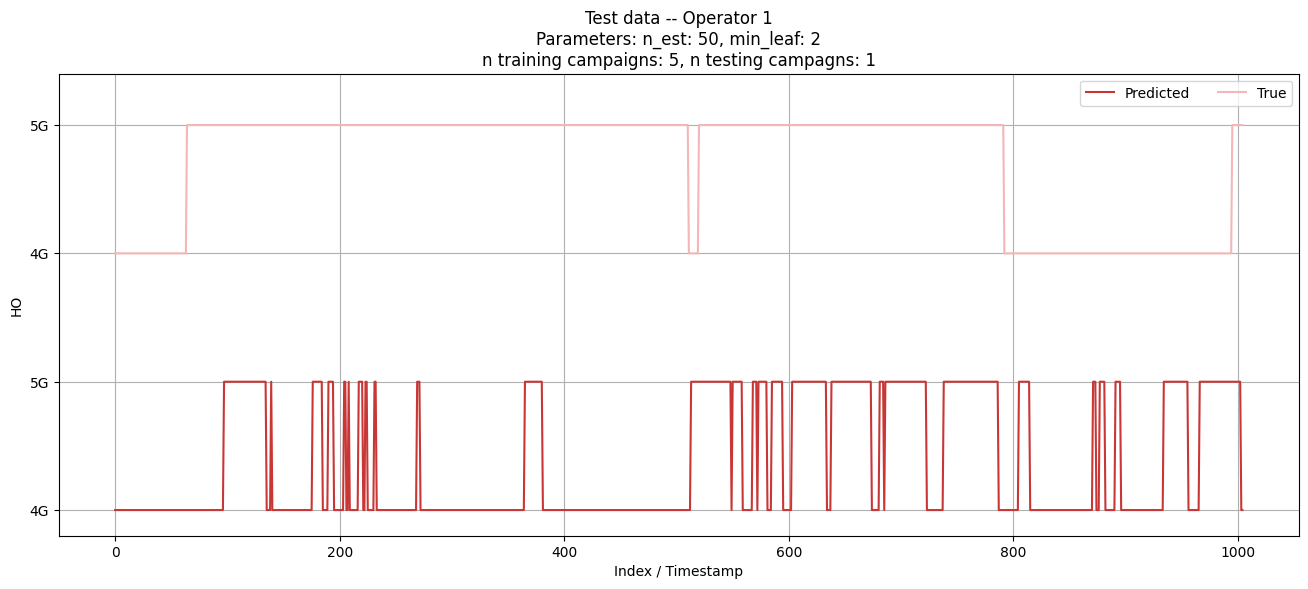

In [44]:
selected_rf_comb = 'n_est: 50, min_leaf: 2'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true'].values

plot_mode(pred=rf_pred, true=rf_true, operator=operator, comb=selected_rf_comb, campaigns=campaigns, test_campaigns=test_campaigns)

#### Include location

In [50]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign', 'Latitude', 'Longitude'])
features = feature_selection[-1].copy()
features.extend(['Latitude', 'Longitude'])

for est in est_try:
    for leaf in min_leaf_size:
        warnings.filterwarnings(action='ignore')
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,"n_est: 5, min_leaf: 1",0.275,0.0,0.0,0.999,0.997,0.999
1,"n_est: 5, min_leaf: 2",0.275,0.0,0.0,0.999,0.994,0.999
2,"n_est: 5, min_leaf: 5",0.275,0.0,0.0,0.997,0.983,0.999
3,"n_est: 5, min_leaf: 7",0.275,0.0,0.0,0.996,0.980,0.999
4,"n_est: 5, min_leaf: 9",0.275,0.0,0.0,0.996,0.979,0.997
...,...,...,...,...,...,...,...
72,"n_est: 300, min_leaf: 5",0.275,0.0,0.0,0.998,0.988,0.998
73,"n_est: 300, min_leaf: 7",0.275,0.0,0.0,0.996,0.979,0.998
74,"n_est: 300, min_leaf: 9",0.275,0.0,0.0,0.995,0.976,0.998
75,"n_est: 300, min_leaf: 12",0.275,0.0,0.0,0.993,0.962,0.999


In [51]:
acc = df_rf_results['Accuracy']
pre = df_rf_results['Precision']
rec = df_rf_results['Recall']

print(f'Accuracy highest: {acc.max():.3f}\nAccuracy mean: {np.mean(acc):.3f}\n\nPrecision highest: {pre.max():.3f}\nPrecision mean: {np.mean(pre):.3f}\n\nRecall highest: {rec.max():.3f}\nRecall mean: {np.mean(rec):.3f}')

Accuracy highest: 0.275
Accuracy mean: 0.275

Precision highest: 0.000
Precision mean: 0.000

Recall highest: 0.000
Recall mean: 0.000


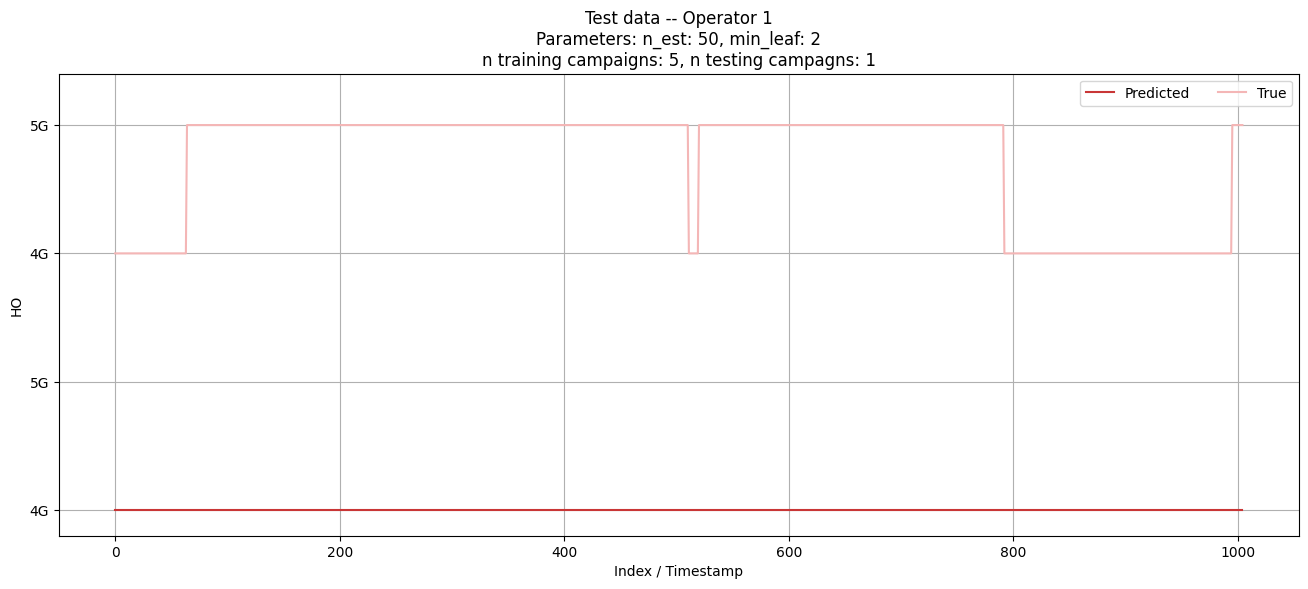

In [52]:
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true'].values

plot_mode(pred=rf_pred, true=rf_true, operator=operator, comb=selected_rf_comb, campaigns=campaigns, test_campaigns=test_campaigns)